In [1]:
# -*- coding: utf-8 -*-
'''
VaDE (Variational Deep Embedding:A Generative Approach to Clustering)

Best clustering accuracy:
MNIST: 94.46% +
Reuters10k: 81.66% +
HHAR: 85.38% +
Reuters_all: 79.38% +

@code author: Zhuxi Jiang
'''
import numpy as np
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
import scipy.io as scio
import gzip
from six.moves import cPickle
import sys
import theano
import theano.tensor as T
import math
from sklearn import mixture
from sklearn.cluster import KMeans
from keras.models import model_from_json
from theano import printing, function

import warnings
warnings.filterwarnings("ignore")


def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon
#=====================================


def cluster_acc(Y_pred, Y):
    from sklearn.utils.linear_assignment_ import linear_assignment
    assert Y_pred.size == Y.size
    D = max(Y_pred.max(), Y.max())+1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(Y_pred.size):
        w[Y_pred[i], Y[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind])*1.0/Y_pred.size, w

#==================================================


def load_data(dataset):
    path = 'dataset/'+dataset+'/'
    if dataset == 'mnist':
        path = path + 'mnist.pkl.gz'
        if path.endswith(".gz"):
            f = gzip.open(path, 'rb')
        else:
            f = open(path, 'rb')

        if sys.version_info < (3,):
            (x_train, y_train), (x_test, y_test) = cPickle.load(f)
        else:
            (x_train, y_train), (x_test, y_test) = cPickle.load(f, encoding="bytes")

        f.close()
        x_train = x_train.astype('float32') / 255.
        x_test = x_test.astype('float32') / 255.
        x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
        x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
        X = np.concatenate((x_train, x_test))
        Y = np.concatenate((y_train, y_test))

    if dataset == 'reuters10k':
        data = scio.loadmat(path+'reuters10k.mat')
        X = data['X']
        Y = data['Y'].squeeze()

    if dataset == 'har':
        data = scio.loadmat(path+'HAR.mat')
        X = data['X']
        X = X.astype('float32')
        Y = data['Y']-1
        X = X[:10200]
        Y = Y[:10200]

    return X, Y


def config_init(dataset):
    if dataset == 'mnist':
        return 784, 1, 10, 0.002, 0.002, 10, 0.9, 0.9, 1, 'sigmoid'
    if dataset == 'reuters10k':
        return 2000, 15, 4, 0.002, 0.002, 5, 0.5, 0.5, 1, 'linear'
    if dataset == 'har':
        return 561, 120, 6, 0.002, 0.00002, 10, 0.9, 0.9, 5, 'linear'


def gmmpara_init():

    theta_init = np.ones(n_centroid)/n_centroid
    u_init = np.zeros((latent_dim, n_centroid))
    lambda_init = np.ones((latent_dim, n_centroid))

    theta_p = theano.shared(np.asarray(
        theta_init, dtype=theano.config.floatX), name="pi")
    u_p = theano.shared(np.asarray(
        u_init, dtype=theano.config.floatX), name="u")
    lambda_p = theano.shared(np.asarray(
        lambda_init, dtype=theano.config.floatX), name="lambda")
    return theta_p, u_p, lambda_p

#================================


def get_gamma(tempz):
    temp_Z = T.transpose(K.repeat(tempz, n_centroid), [0, 2, 1])
    temp_u_tensor3 = T.repeat(u_p.dimshuffle('x', 0, 1), batch_size, axis=0)
    temp_lambda_tensor3 = T.repeat(
        lambda_p.dimshuffle('x', 0, 1), batch_size, axis=0)
    temp_theta_tensor3 = theta_p.dimshuffle(
        'x', 'x', 0)*T.ones((batch_size, latent_dim, n_centroid))

    temp_p_c_z = K.exp(K.sum((K.log(temp_theta_tensor3)-0.5*K.log(2*math.pi*temp_lambda_tensor3) -
                              K.square(temp_Z-temp_u_tensor3)/(2*temp_lambda_tensor3)), axis=1))+1e-10
    return temp_p_c_z/K.sum(temp_p_c_z, axis=-1, keepdims=True)
#=====================================================


def vae_loss(x, x_decoded_mean):
    Z = T.transpose(K.repeat(z, n_centroid), [0, 2, 1])
    z_mean_t = T.transpose(K.repeat(z_mean, n_centroid), [0, 2, 1])
    z_log_var_t = T.transpose(K.repeat(z_log_var, n_centroid), [0, 2, 1])
    u_tensor3 = T.repeat(u_p.dimshuffle('x', 0, 1), batch_size, axis=0)
    lambda_tensor3 = T.repeat(
        lambda_p.dimshuffle('x', 0, 1), batch_size, axis=0)
    theta_tensor3 = theta_p.dimshuffle(
        'x', 'x', 0)*T.ones((batch_size, latent_dim, n_centroid))

    p_c_z = K.exp(K.sum((K.log(theta_tensor3)-0.5*K.log(2*math.pi*lambda_tensor3) -
                         K.square(Z-u_tensor3)/(2*lambda_tensor3)), axis=1))+1e-10

    gamma = p_c_z/K.sum(p_c_z, axis=-1, keepdims=True)
    gamma_t = K.repeat(gamma, latent_dim)

    if datatype == 'sigmoid':
        loss = alpha*original_dim * objectives.binary_crossentropy(x, x_decoded_mean)\
            + K.sum(0.5*gamma_t*(latent_dim*K.log(math.pi*2)+K.log(lambda_tensor3)+K.exp(z_log_var_t)/lambda_tensor3+K.square(z_mean_t-u_tensor3)/lambda_tensor3), axis=(1, 2))\
            - 0.5*K.sum(z_log_var+1, axis=-1)\
            - K.sum(K.log(K.repeat_elements(theta_p.dimshuffle('x', 0), batch_size, 0))*gamma, axis=-1)\
            + K.sum(K.log(gamma)*gamma, axis=-1)
    else:
        loss = alpha*original_dim * objectives.mean_squared_error(x, x_decoded_mean)\
            + K.sum(0.5*gamma_t*(latent_dim*K.log(math.pi*2)+K.log(lambda_tensor3)+K.exp(z_log_var_t)/lambda_tensor3+K.square(z_mean_t-u_tensor3)/lambda_tensor3), axis=(1, 2))\
            - 0.5*K.sum(z_log_var+1, axis=-1)\
            - K.sum(K.log(K.repeat_elements(theta_p.dimshuffle('x', 0), batch_size, 0))*gamma, axis=-1)\
            + K.sum(K.log(gamma)*gamma, axis=-1)

    return loss
#================================


def load_pretrain_weights(vade, dataset):
    ae = model_from_json(open('pretrain_weights/ae_'+dataset+'.json').read())
    ae.load_weights('pretrain_weights/ae_'+dataset+'_weights.h5')
    vade.layers[1].set_weights(ae.layers[0].get_weights())
    vade.layers[2].set_weights(ae.layers[1].get_weights())
    vade.layers[3].set_weights(ae.layers[2].get_weights())
    vade.layers[4].set_weights(ae.layers[3].get_weights())
    vade.layers[-1].set_weights(ae.layers[-1].get_weights())
    vade.layers[-2].set_weights(ae.layers[-2].get_weights())
    vade.layers[-3].set_weights(ae.layers[-3].get_weights())
    vade.layers[-4].set_weights(ae.layers[-4].get_weights())
    sample = sample_output.predict(X, batch_size=batch_size)
    if dataset == 'mnist':
        g = mixture.GMM(n_components=n_centroid, covariance_type='diag')
        g.fit(sample)
        u_p.set_value(floatX(g.means_.T))
        lambda_p.set_value((floatX(g.covars_.T)))
    if dataset == 'reuters10k':
        k = KMeans(n_clusters=n_centroid)
        k.fit(sample)
        u_p.set_value(floatX(k.cluster_centers_.T))
    if dataset == 'har':
        g = mixture.GMM(n_components=n_centroid,
                        covariance_type='diag', random_state=3)
        g.fit(sample)
        u_p.set_value(floatX(g.means_.T))
        lambda_p.set_value((floatX(g.covars_.T)))
    print ('pretrain weights loaded!')
    return vade
#===================================


def lr_decay():
    if dataset == 'mnist':
        adam_nn.lr.set_value(
            floatX(max(adam_nn.lr.get_value()*decay_nn, 0.0002)))
        adam_gmm.lr.set_value(
            floatX(max(adam_gmm.lr.get_value()*decay_gmm, 0.0002)))
    else:
        adam_nn.lr.set_value(floatX(adam_nn.lr.get_value()*decay_nn))
        adam_gmm.lr.set_value(floatX(adam_gmm.lr.get_value()*decay_gmm))
    print ('lr_nn:%f' % adam_nn.lr.get_value())
    print ('lr_gmm:%f' % adam_gmm.lr.get_value())


def epochBegin(epoch):

    if epoch % decay_n == 0 and epoch != 0:
        lr_decay()
    '''
    sample = sample_output.predict(X,batch_size=batch_size)
    g = mixture.GMM(n_components=n_centroid,covariance_type='diag')
    g.fit(sample)
    p=g.predict(sample)
    acc_g=cluster_acc(p,Y)

    if epoch <1 and ispretrain == False:
        u_p.set_value(floatX(g.means_.T))
        print ('no pretrain,random init!')
    '''
    gamma = gamma_output.predict(X, batch_size=batch_size)
    acc = cluster_acc(np.argmax(gamma, axis=1), Y)
    global accuracy
    accuracy += [acc[0]]
    if epoch > 0:
        # print ('acc_gmm_on_z:%0.8f'%acc_g[0])
        print ('acc_p_c_z:%0.8f' % acc[0])
    if epoch == 1 and dataset == 'har' and acc[0] < 0.77:
        print ('=========== HAR dataset:bad init!Please run again! ============')
        sys.exit(0)


class EpochBegin(Callback):
    def on_epoch_begin(self, epoch, logs={}):
        epochBegin(epoch)
#==============================================


dataset = 'mnist'
db = sys.argv[1]
if db in ['mnist', 'reuters10k', 'har']:
    dataset = db
print ('training on: ' + dataset)
ispretrain = True
batch_size = 100
latent_dim = 10
intermediate_dim = [500, 500, 2000]
theano.config.floatX = 'float32'
accuracy = []
X, Y = load_data(dataset)
original_dim, epoch, n_centroid, lr_nn, lr_gmm, decay_n, decay_nn, decay_gmm, alpha, datatype = config_init(
    dataset)
theta_p, u_p, lambda_p = gmmpara_init()
#===================

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim[0], activation='relu')(x)
h = Dense(intermediate_dim[1], activation='relu')(h)
h = Dense(intermediate_dim[2], activation='relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
h_decoded = Dense(intermediate_dim[-1], activation='relu')(z)
h_decoded = Dense(intermediate_dim[-2], activation='relu')(h_decoded)
h_decoded = Dense(intermediate_dim[-3], activation='relu')(h_decoded)
x_decoded_mean = Dense(original_dim, activation=datatype)(h_decoded)

#========================
Gamma = Lambda(get_gamma, output_shape=(n_centroid,))(z)
sample_output = Model(x, z_mean)
gamma_output = Model(x, Gamma)
#===========================================
vade = Model(x, x_decoded_mean)
if ispretrain == True:
    vade = load_pretrain_weights(vade, dataset)
adam_nn = Adam(lr=lr_nn, epsilon=1e-4)
adam_gmm = Adam(lr=lr_gmm, epsilon=1e-4)
vade.compile(optimizer=adam_nn, loss=vae_loss, add_trainable_weights=[
             theta_p, u_p, lambda_p], add_optimizer=adam_gmm)
epoch_begin = EpochBegin()
#-------------------------------------------------------

vade.fit(X, X,
         shuffle=True,
         nb_epoch=epoch,
         batch_size=batch_size,
         callbacks=[epoch_begin])

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


training on: mnist
pretrain weights loaded!
Epoch 1/1
70000/70000 [==============================] - 82s - loss: 201.4431    


In [19]:
import matplotlib as mlp
from matplotlib import pyplot as plt
%matplotlib inline

In [32]:
out = gamma_output.predict(X, batch_size=batch_size)
acc = cluster_acc(np.argmax(out, axis=1), Y)

print ('MNIST dataset VaDE - clustering accuracy: %.2f%%' % (acc[0]*100))

MNIST dataset VaDE - clustering accuracy: 79.54%


In [34]:
def mnist_gene(ind, g_u, g_lambda, g_theta):
    mnist_nice_png = np.zeros((280, 280))
    for i in range(10):
        u = g_u[:, i].eval()
        l = g_lambda[:, i].eval()
        sample_n = 10
        count = 0
        while count < sample_n:
            z_sample = np.random.multivariate_normal(u, np.diag(l), (1,)).astype(np.float32)
            p = get_posterior(z_sample, g_u.eval(), g_lambda.eval(), g_theta.eval())[i]
            if p > 0.1:
                img = x_decoded_mean.eval({h_decoded: h_decoded.eval({z: z_sample})}).reshape((28, 28))*255.0
                mnist_nice_png[i*28:(i+1)*28, count*28:(count+1)*28] = img
                count += 1
    return np.asarray(mnist_nice_png, dtype=np.uint8)


def get_posterior(z, u, l, sita):
    z_m = np.repeat(np.transpose(z), n_centroid, 1)
    posterior = np.exp(
        np.sum((np.log(sita)-0.5*np.log(2*math.pi*l) -
                np.square(z_m-u)/(2*l)), axis=0)
    )
    return posterior/np.sum(posterior, axis=-1, keepdims=True)

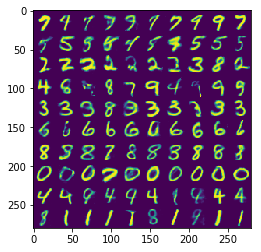

In [35]:
digit_image = mnist_gene(out, u_p, lambda_p, theta_p)
plt.imshow(digit_image)
plt.show()